# Zipline Algorithm Analysis

Here's an example where we run an algorithm with zipline, then produce tear sheets for that algorithm.

## Imports & Settings
Import pyfolio and zipline, and ingest the pricing data for backtesting.

You may have to install [Zipline](https://zipline.ml4trading.io/) first; you can do so using either:

In [ ]:
# !pip install zipline-reloaded

or:

In [ ]:
# !conda install -c ml4t zipline-reloaded

In [1]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

import zipline
%load_ext zipline

## Ingest Zipline Bundle

If you have not yet downloaded [data for Zipline](https://zipline.ml4trading.io/bundles.html), you need to do so first (uncomment and execute the following cell):

In [2]:
# !zipline ingest

## Run Zipline algorithm
This algorithm can also be adjusted to execute a modified, or completely different, trading strategy.

In [5]:
%%zipline --start 2004-1-1 --end 2010-1-1 -o results.pickle --no-benchmark

# Zipline trading algorithm
# Taken from zipline.examples.olmar

import numpy as np

from zipline.finance import commission, slippage

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0))
    algo.set_slippage(slippage.FixedSlippage(spread=0))


def handle_data(algo, data):
    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    for i, sid in enumerate(algo.sids):
        algo.order_target_percent(sid, desired_port[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w

,period_open,period_close,starting_cash,ending_cash,portfolio_value,longs_count,shorts_count,long_value,short_value,returns,...,period_label,algorithm_period_return,algo_volatility,benchmark_period_return,benchmark_volatility,alpha,beta,sharpe,sortino,max_drawdown
2004-01-02 21:00:00+00:00,2004-01-02 14:31:00+00:00,2004-01-02 21:00:00+00:00,1.000000e+07,1.000000e+07,1.000000e+07,0,0,0.000000e+00,0.0,0.000000,...,2004-01,0.000000,NaN,0.0,NaN,None,None,NaN,NaN,0.000000
2004-01-05 21:00:00+00:00,2004-01-05 14:31:00+00:00,2004-01-05 21:00:00+00:00,1.000000e+07,-1.261747e+05,1.000000e+07,7,0,1.012617e+07,0.0,0.000000,...,2004-01,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN,0.000000
2004-01-06 21:00:00+00:00,2004-01-06 14:31:00+00:00,2004-01-06 21:00:00+00:00,-1.261747e+05,-1.639664e+04,1.007876e+07,7,0,1.009515e+07,0.0,0.007876,...,2004-01,0.007876,0.072181,0.0,0.0,None,None,9.165151,NaN,0.000000
2004-01-07 21:00:00+00:00,2004-01-07 14:31:00+00:00,2004-01-07 21:00:00+00:00,-1.639664e+04,2.168894e+04,1.013911e+07,6,0,1.011742e+07,0.0,0.005989,...,2004-01,0.013911,0.064700,0.0,0.0,None,None,13.499945,NaN,0.000000
2004-01-08 21:00:00+00:00,2004-01-08 14:31:00+00:00,2004-01-08 21:00:00+00:00,2.168894e+04,3.773005e+04,9.897065e+06,4,0,9.859335e+06,0.0,-0.023873,...,2004-01,-0.010293,0.202012,0.0,0.0,None,None,-2.497026,-2.976346,-0.023873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-24 18:00:00+00:00,2009-12-24 14:31:00+00:00,2009-12-24 18:00:00+00:00,1.503458e+04,2.915782e+04,1.613946e+07,4,0,1.611030e+07,0.0,0.000973,...,2009-12,0.613946,0.256421,0.0,0.0,None,None,0.440104,0.643345,-0.602991
2009-12-28 21:00:00+00:00,2009-12-28 14:31:00+00:00,2009-12-28 21:00:00+00:00,2.915782e+04,-5.396543e+03,1.627136e+07,4,0,1.627676e+07,0.0,0.008173,...,2009-12,0.627136,0.256355,0.0,0.0,None,None,0.445253,0.650920,-0.602991
2009-12-29 21:00:00+00:00,2009-12-29 14:31:00+00:00,2009-12-29 21:00:00+00:00,-5.396543e+03,-1.236016e+04,1.639258e+07,3,0,1.640494e+07,0.0,0.007450,...,2009-12,0.639258,0.256286,0.0,0.0,None,None,0.449932,0.657801,-0.602991
2009-12-30 21:00:00+00:00,2009-12-30 14:31:00+00:00,2009-12-30 21:00:00+00:00,-1.236016e+04,-1.618491e+05,1.643268e+07,5,0,1.659453e+07,0.0,0.002446,...,2009-12,0.643268,0.256203,0.0,0.0,None,None,0.451374,0.659913,-0.602991


## Extract metrics
Get the returns, positions, and transactions from the zipline backtest object.

In [6]:
import pandas as pd

results = pd.read_pickle('results.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

## Single plot example
Make one plot of the top 5 drawdown periods.

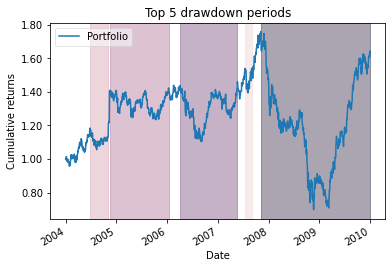

In [8]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date');

## Full tear sheet example
Create a full tear sheet for our algorithm. As an example, set the live start date to something arbitrary.

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.30,2007-11-06,2008-11-20,NaT,NaN
1,23.25,2006-04-06,2006-09-07,2007-05-22,294
2,12.51,2004-11-15,2005-10-12,2006-01-11,303
3,10.90,2004-06-25,2004-08-12,2004-11-04,95
4,9.47,2007-07-16,2007-08-06,2007-09-04,37


Stress Events,mean,min,max
Lehman,-0.28%,-7.42%,4.40%
Aug07,0.35%,-2.96%,3.03%
Mar08,-0.43%,-3.10%,3.34%
Sept08,-0.68%,-7.42%,3.99%
2009Q1,-0.35%,-4.98%,3.36%
2009Q2,0.71%,-3.78%,6.17%
Low Volatility Bull Market,0.01%,-6.11%,6.45%
GFC Crash,-0.08%,-7.58%,9.71%
Recovery,0.32%,-3.78%,6.17%


Top 10 long positions of all time,max
sid,
COST,100.75%
MMM,92.36%
CERN,84.47%
DELL,72.76%
AMD,71.05%
INTC,69.19%
GPS,62.11%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
COST,100.75%
MMM,92.36%
CERN,84.47%
DELL,72.76%
AMD,71.05%
INTC,69.19%
GPS,62.11%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,3988.00,3.00,3985.00
Percent profitable,0.49,0.00,0.49
Winning round_trips,1936.00,0.00,1936.00
Losing round_trips,2041.00,0.00,2041.00
Even round_trips,11.00,3.00,8.00


PnL stats,All trades,Short trades,Long trades
Total profit,$6120420.82,$0.00,$6120420.82
Gross profit,$37885663.44,$0.00,$37885663.44
Gross loss,$-31765242.63,$0.00,$-31765242.63
Profit factor,$1.19,NaN,$1.19
Avg. trade net profit,$1534.71,$0.00,$1535.86
Avg. winning trade,$19569.04,NaN,$19569.04
Avg. losing trade,$-15563.57,NaN,$-15563.57
Ratio Avg. Win:Avg. Loss,$1.26,NaN,$1.26
Largest winning trade,$1553166.81,$0.00,$1553166.81
Largest losing trade,$-1252569.18,$0.00,$-1252569.18


Duration stats,All trades,Short trades,Long trades
Avg duration,21 days 18:41:17.933801404,0 days 20:59:59,21 days 19:03:57.591718946
Median duration,17 days 23:00:00,0 days 20:59:59,17 days 23:00:00
Longest duration,109 days 01:00:00,0 days 20:59:59,109 days 01:00:00
Shortest duration,0 days 03:00:01,0 days 20:59:59,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.01%,-0.02%,0.01%
Avg returns winning,0.16%,NaN,0.16%
Avg returns losing,-0.13%,-0.02%,-0.13%
Median returns all round_trips,-0.00%,-0.00%,-0.00%
Median returns winning,0.02%,NaN,0.02%
Median returns losing,-0.01%,-0.00%,-0.01%
Largest winning trade,12.13%,-0.00%,12.13%
Largest losing trade,-9.15%,-0.05%,-9.15%


Symbol stats,AMD,CERN,COST,DELL,GPS,INTC,MMM
Avg returns all round_trips,0.03%,0.03%,0.00%,-0.00%,0.03%,-0.13%,0.07%
Avg returns winning,0.12%,0.16%,0.11%,0.12%,0.14%,0.14%,0.25%
Avg returns losing,-0.07%,-0.10%,-0.09%,-0.11%,-0.11%,-0.26%,-0.15%
Median returns all round_trips,0.00%,-0.00%,-0.00%,-0.00%,0.00%,-0.00%,0.00%
Median returns winning,0.01%,0.01%,0.02%,0.01%,0.02%,0.01%,0.04%
Median returns losing,-0.01%,-0.01%,-0.01%,-0.01%,-0.01%,-0.02%,-0.01%
Largest winning trade,2.22%,12.13%,2.06%,3.36%,3.16%,1.63%,7.84%
Largest losing trade,-2.87%,-5.52%,-4.20%,-4.87%,-7.19%,-9.15%,-8.30%


Profitability (PnL / PnL total) per name,
symbol,
INTC,45.09%
COST,42.43%
CERN,35.53%
MMM,13.51%
GPS,-2.48%
AMD,-7.16%
DELL,-26.91%


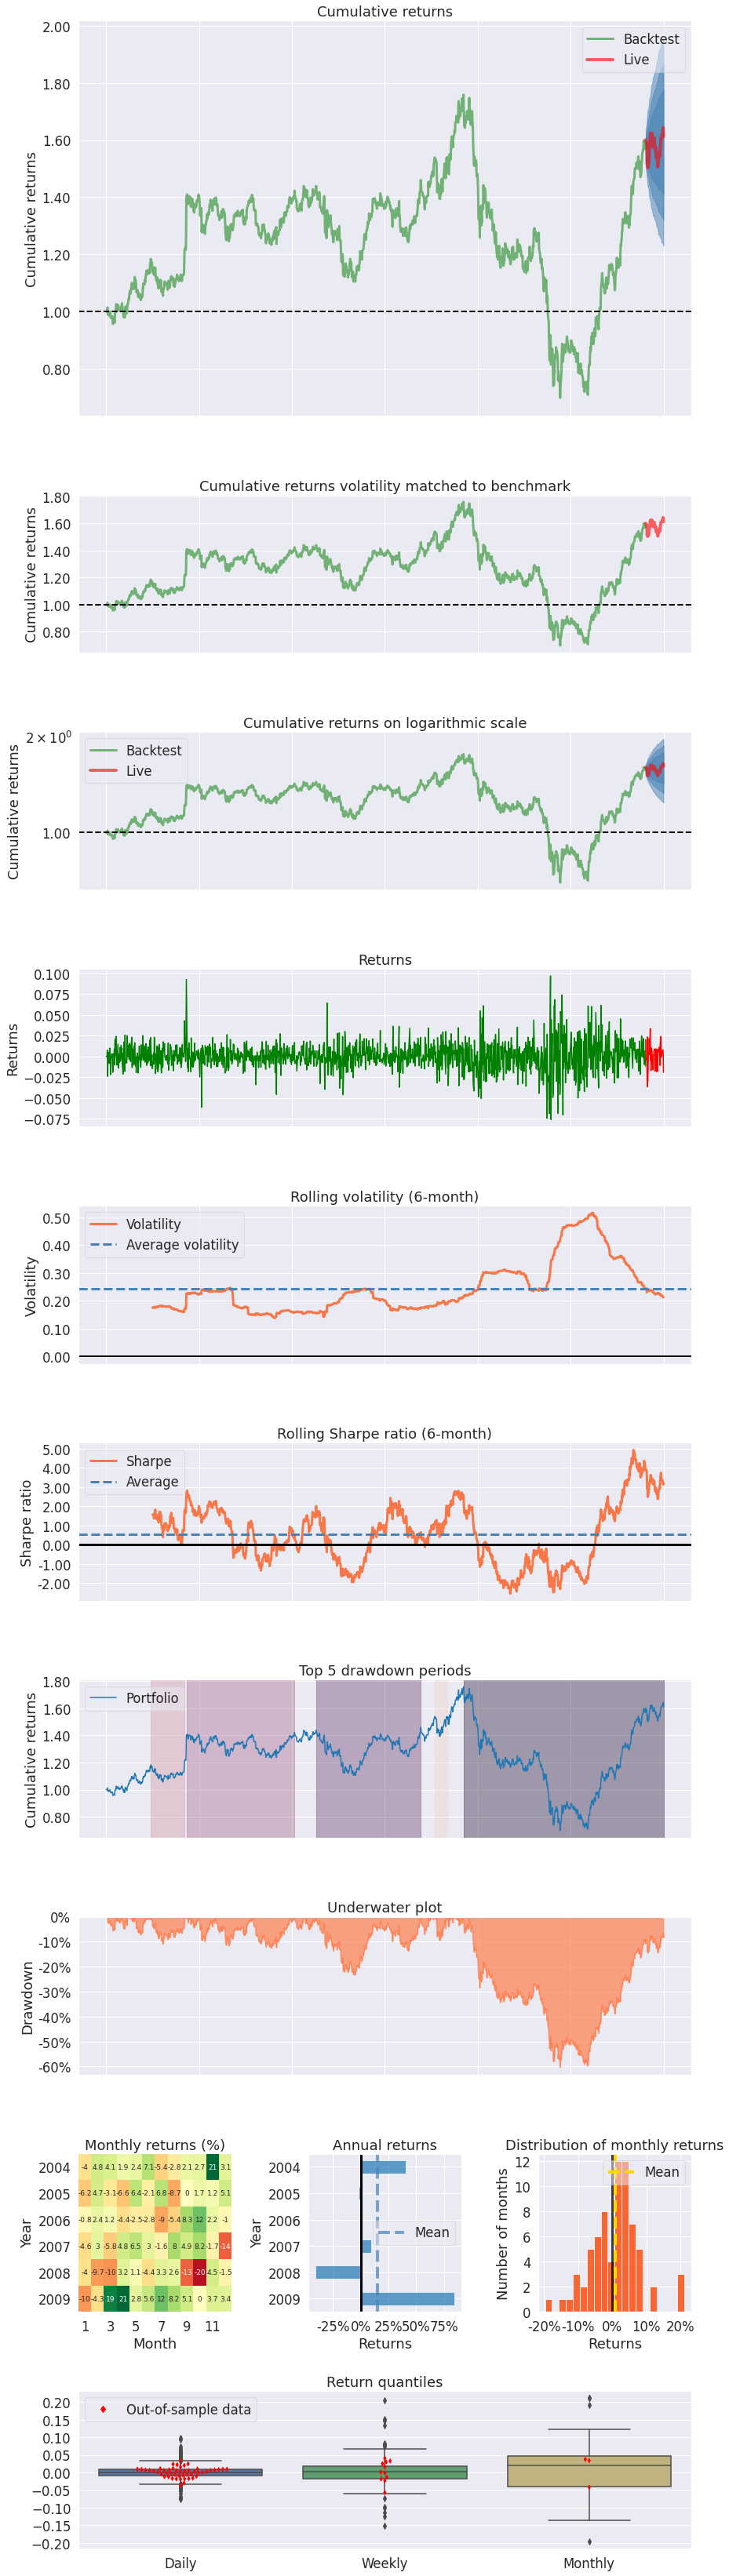

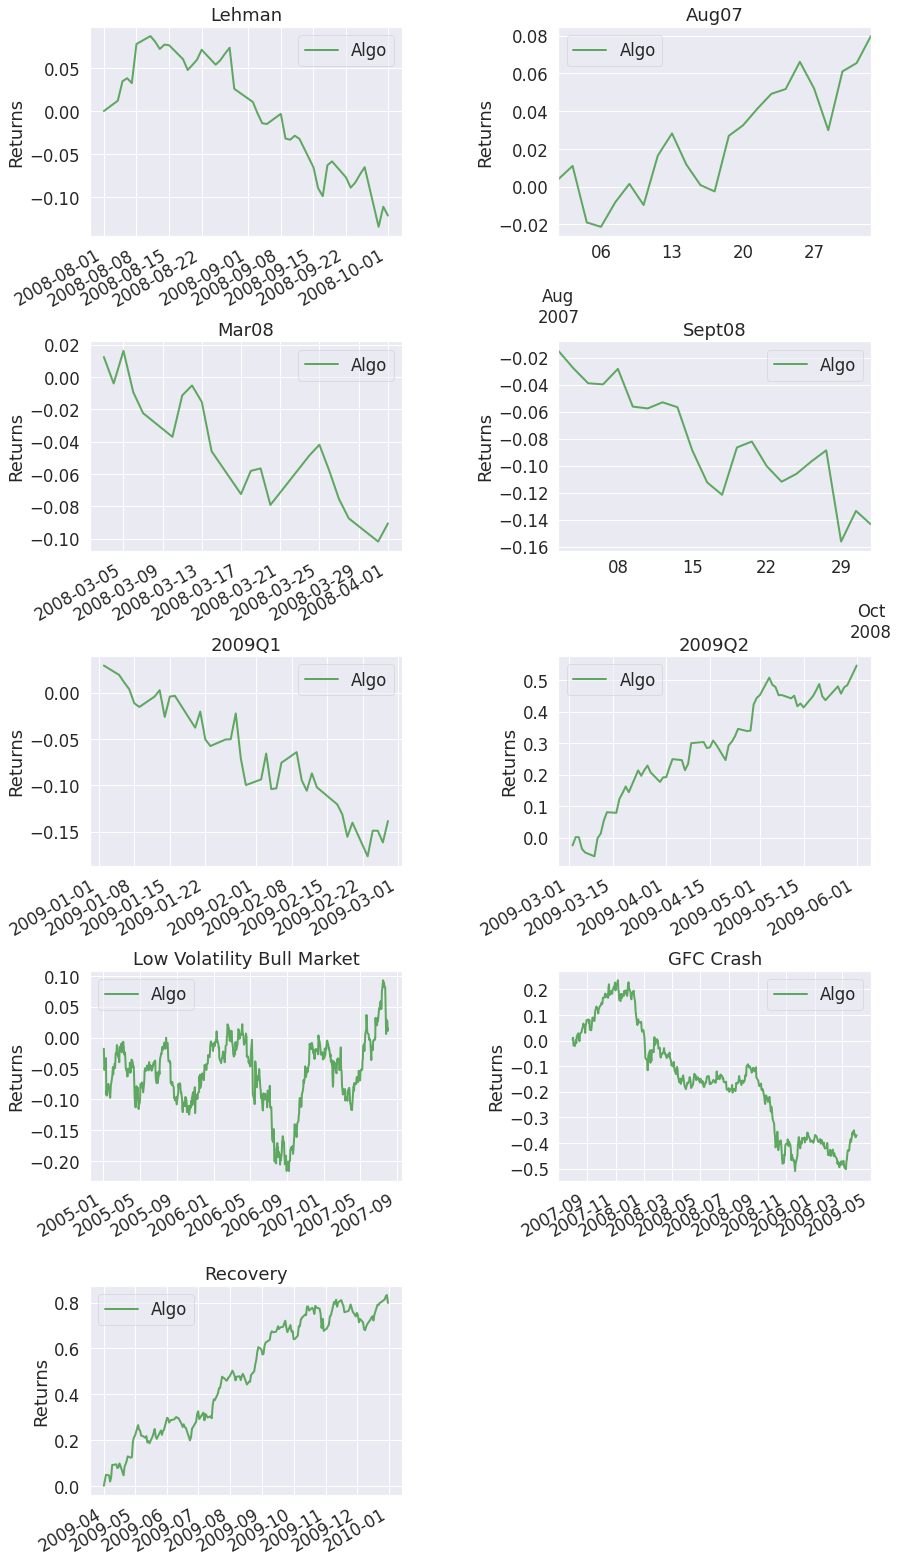

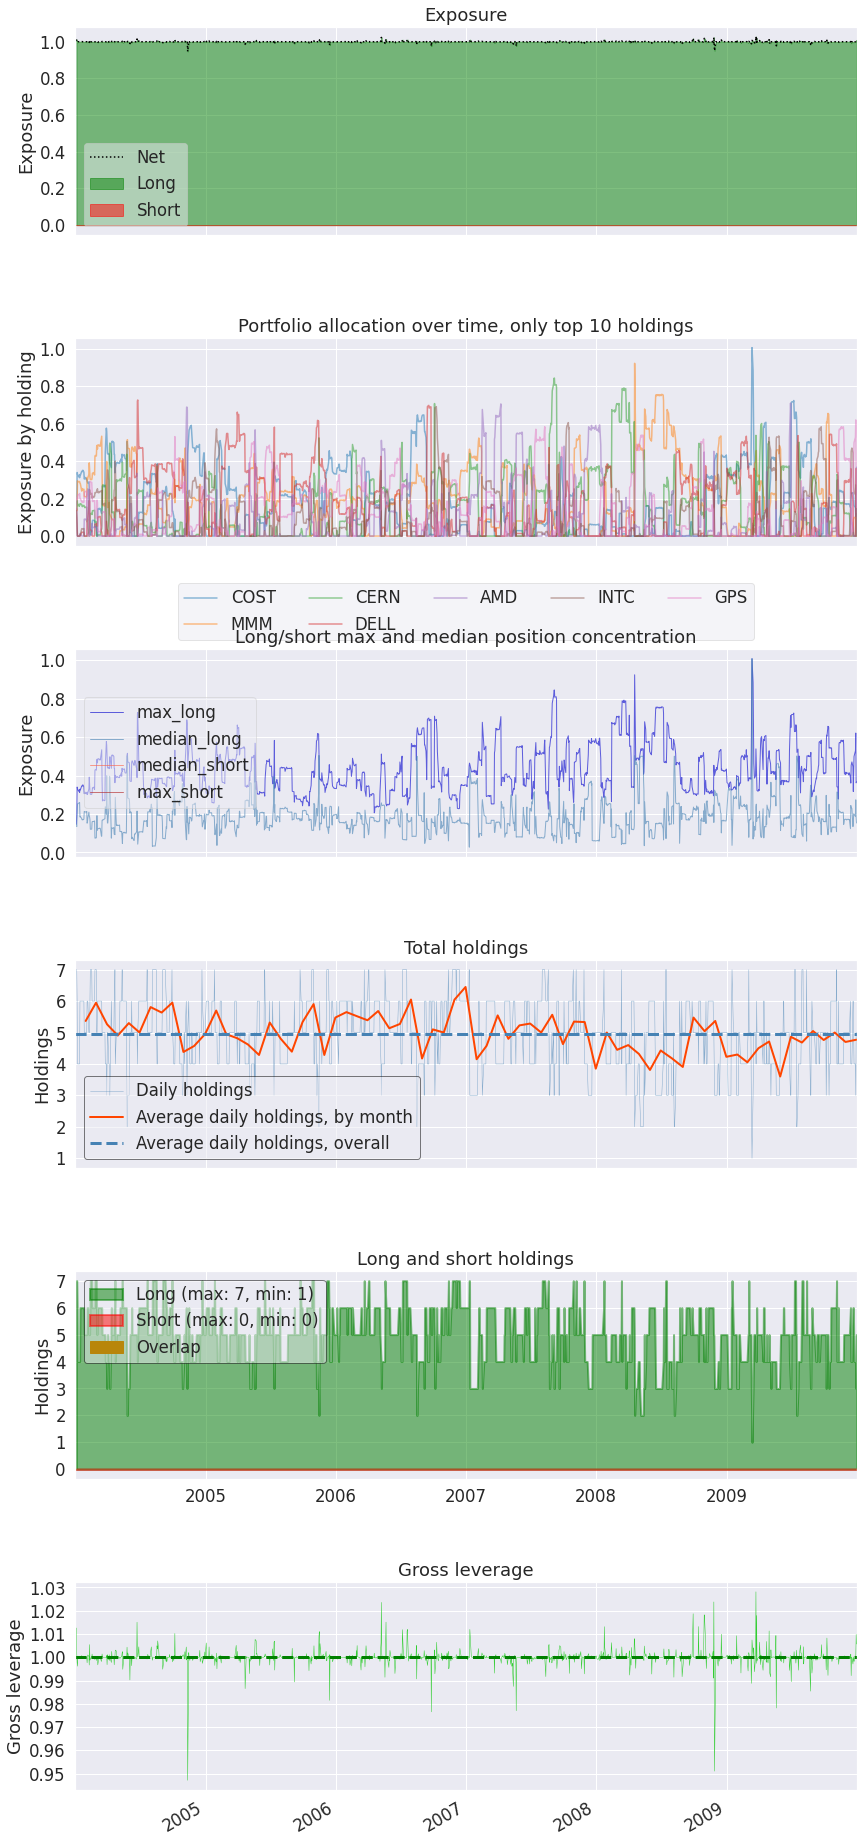

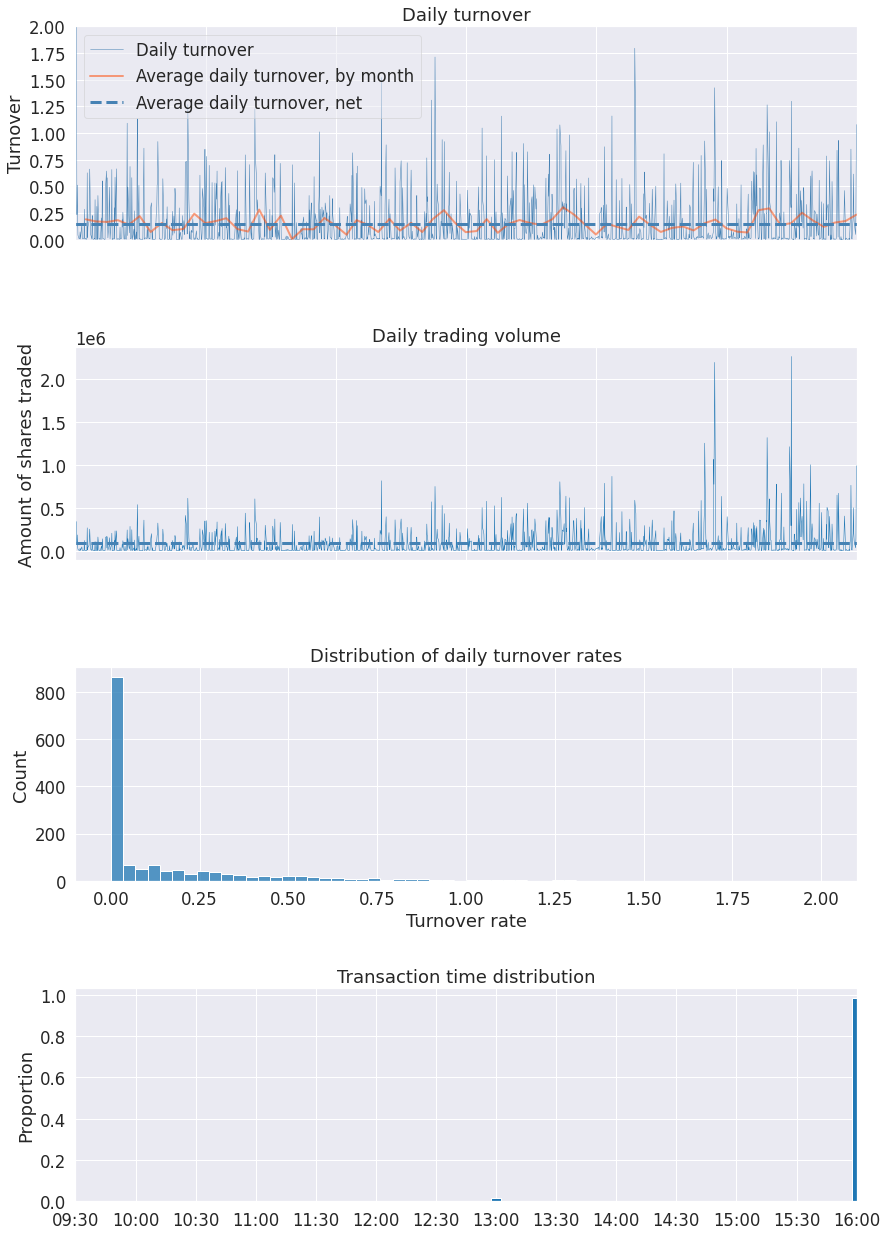

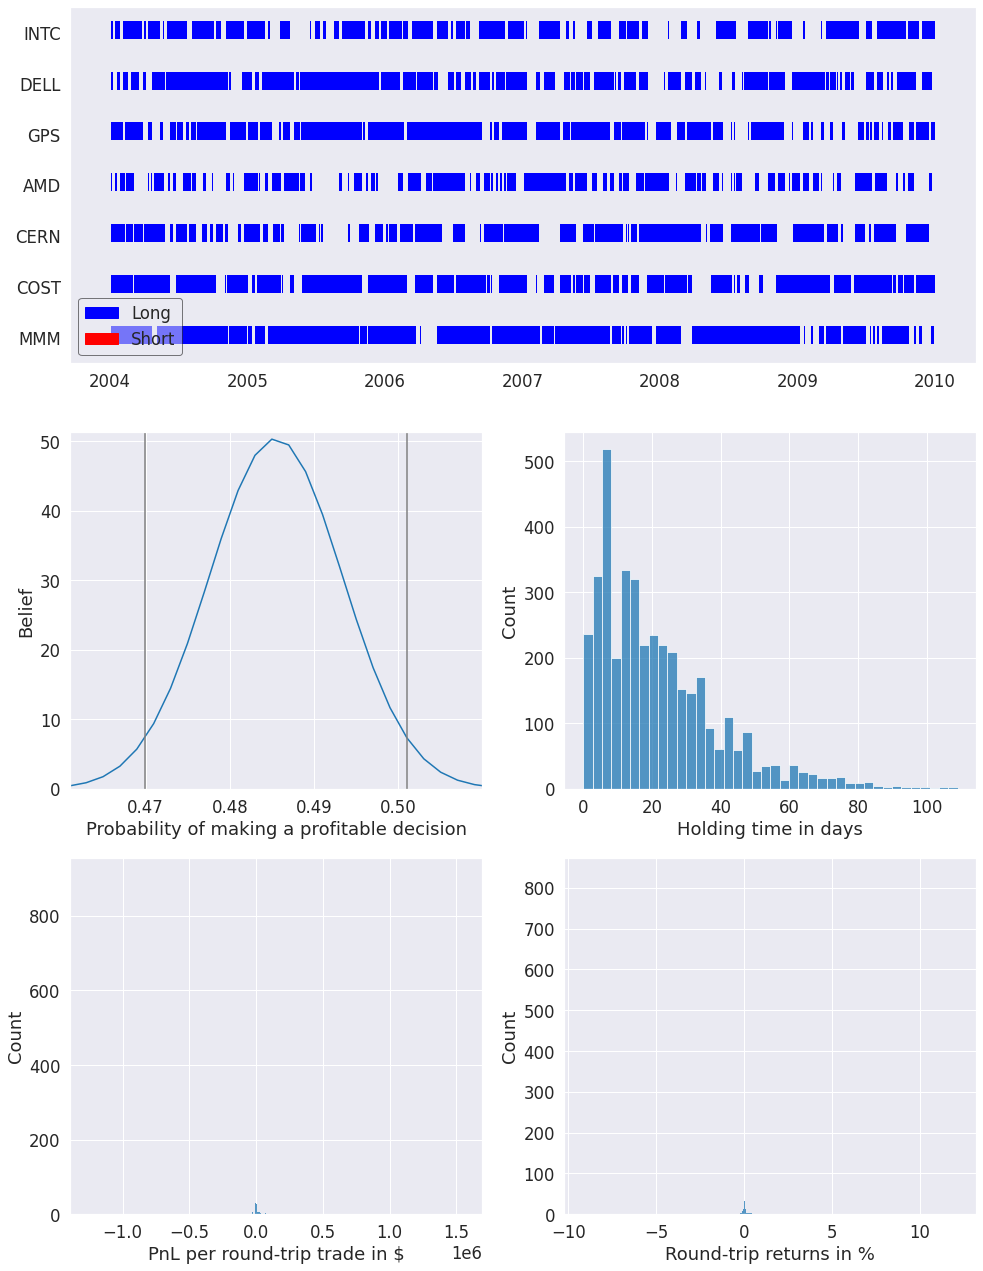

In [9]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', round_trips=True)

## Suppressing symbol output

When sharing tear sheets it might be undesirable to display which symbols where used by a strategy. To suppress these in the tear sheet you can pass `hide_positions=True`.

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31
In-sample months: 69
Out-of-sample months: 2


,All,In-sample,Out-of-sample
Annual return,8.3%,8.1%,14.9%
Cumulative returns,61.1%,56.8%,2.7%
Annual volatility,25.6%,25.7%,22.0%
Sharpe ratio,0.44,0.43,0.74
Calmar ratio,0.14,0.13,2.03
Stability,0.00,0.01,0.04
Max drawdown,-60.3%,-60.3%,-7.3%
Omega ratio,1.08,1.08,1.13
Sortino ratio,0.64,0.63,1.04
Skew,0.21,0.22,-0.29


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.30,2007-11-06,2008-11-20,NaT,NaN
1,23.25,2006-04-06,2006-09-07,2007-05-22,294
2,12.52,2004-11-15,2005-10-12,2006-01-11,303
3,10.90,2004-06-25,2004-08-12,2004-11-04,95
4,9.47,2007-07-16,2007-08-06,2007-09-04,37


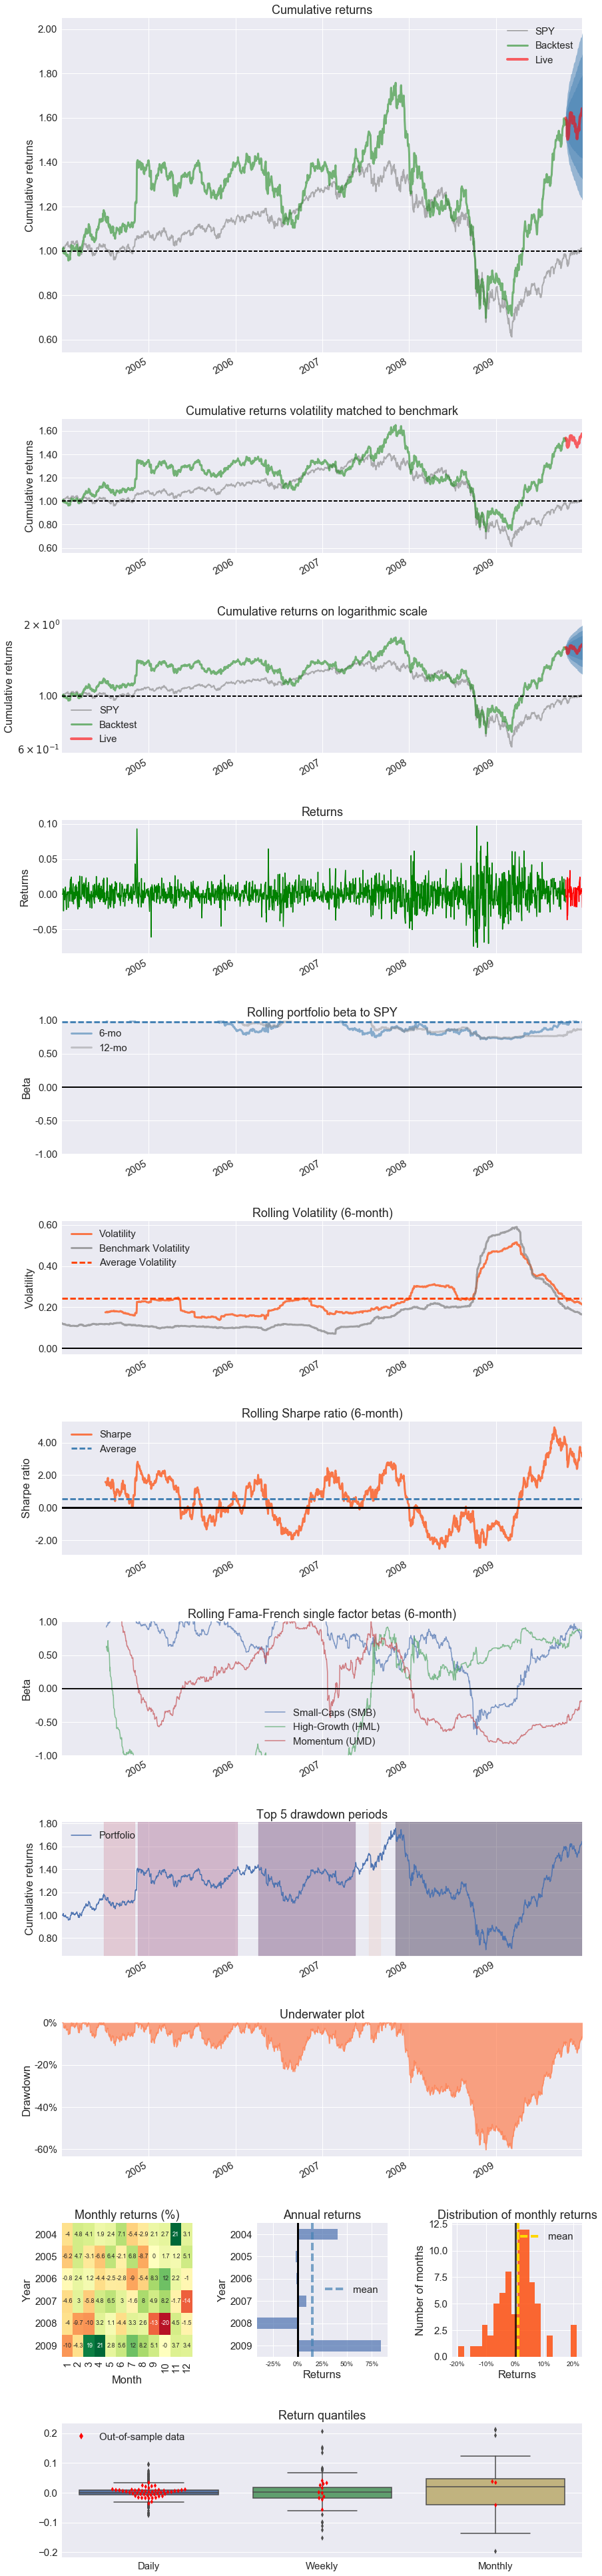

Stress Events,mean,min,max
Lehmann,-0.28%,-7.41%,4.40%
Aug07,0.35%,-2.96%,3.03%
Mar08,-0.43%,-3.10%,3.34%
Sept08,-0.68%,-7.41%,3.99%
2009Q1,-0.35%,-4.98%,3.36%
2009Q2,0.71%,-3.78%,6.17%
Low Volatility Bull Market,0.01%,-6.11%,6.45%
GFC Crash,-0.08%,-7.58%,9.71%
Recovery,0.32%,-3.78%,6.17%


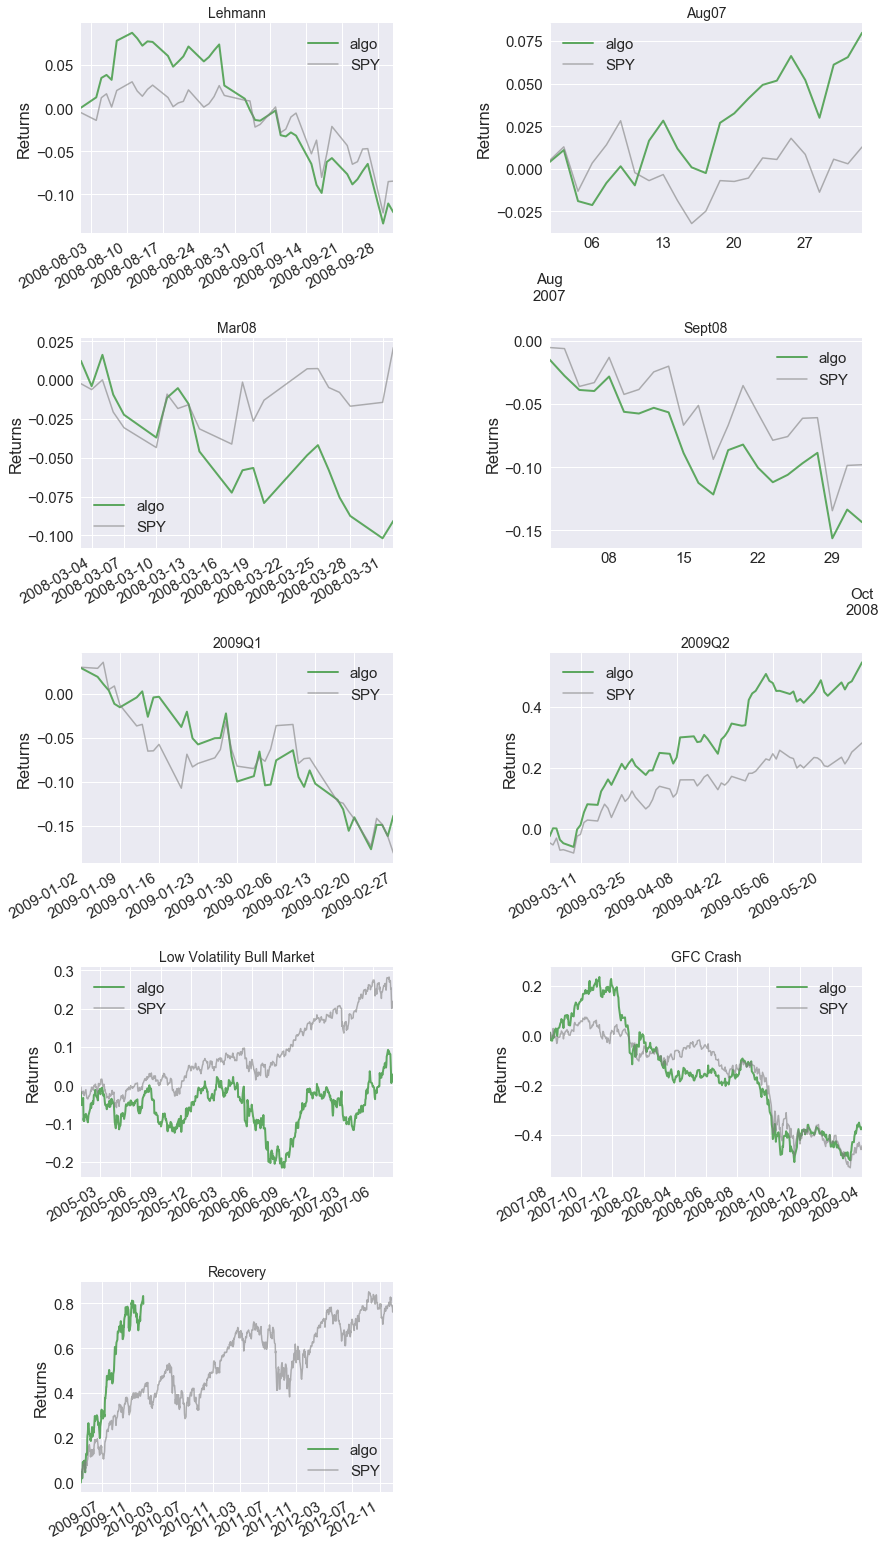

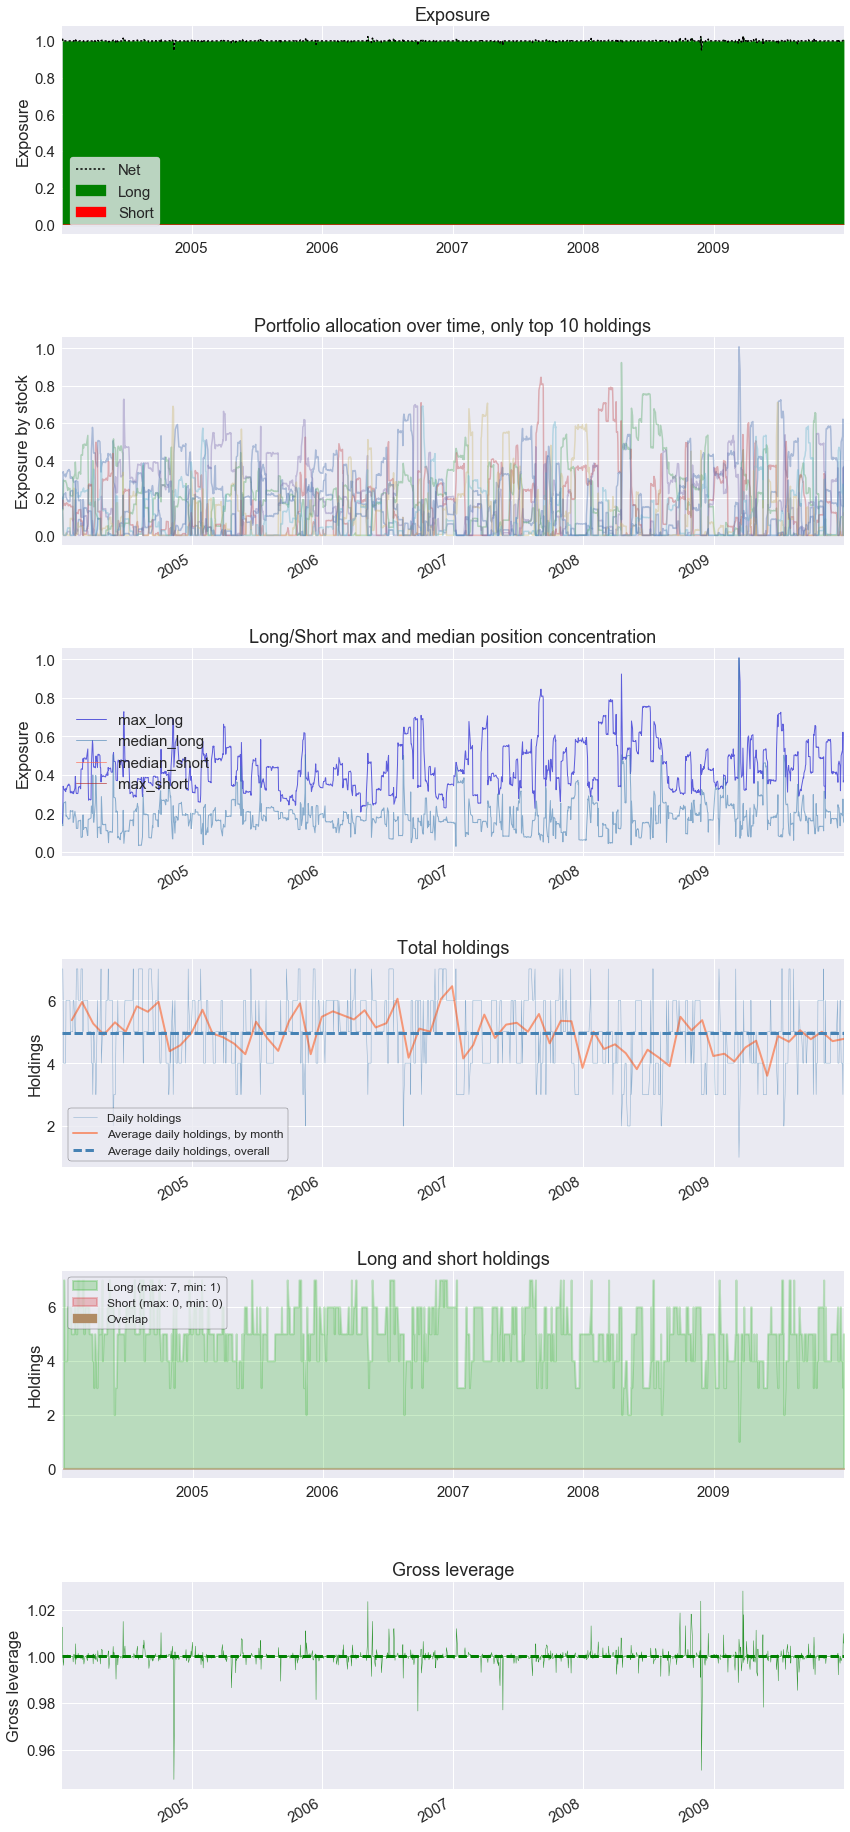

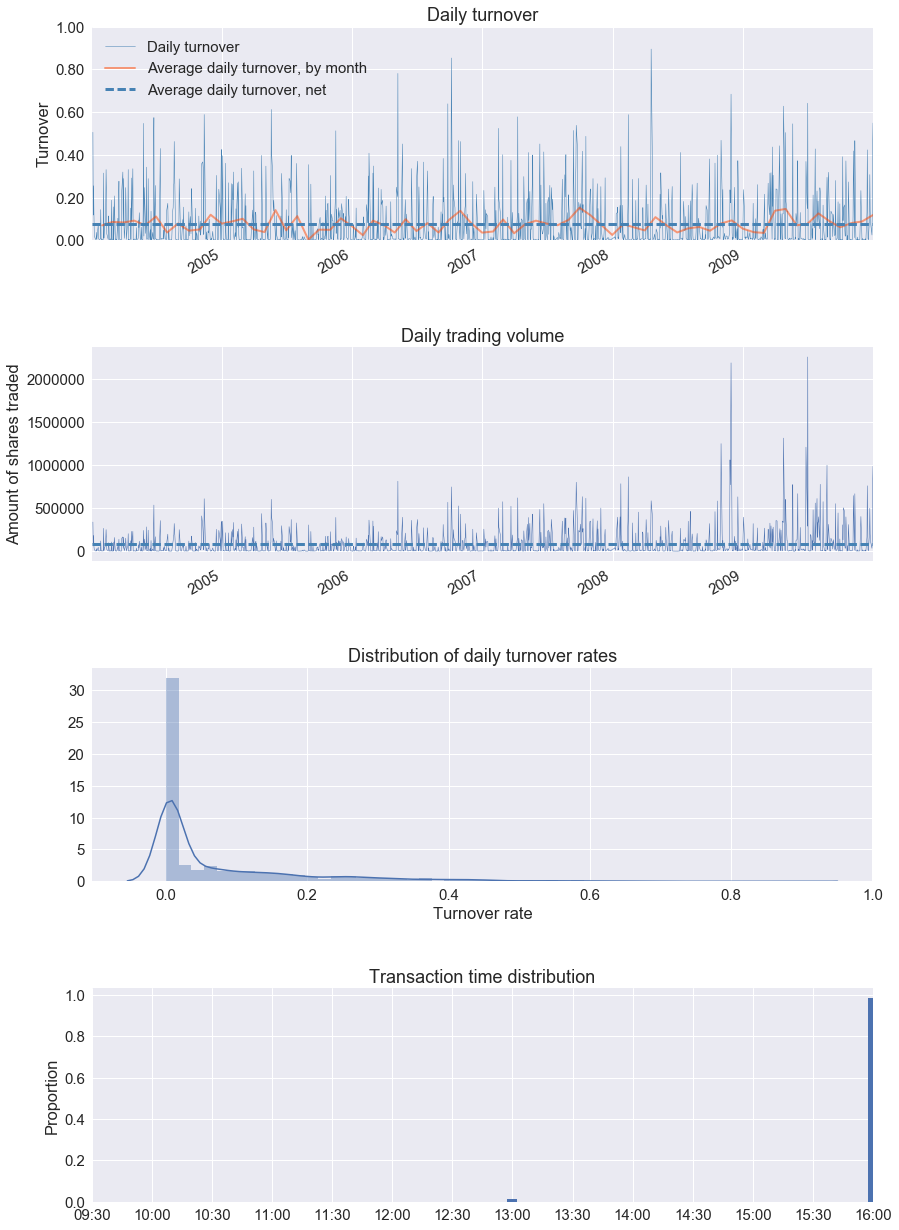

In [6]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', hide_positions=True)